In [1]:
# Imports and scripts
import pandas as pd
#import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
    import GatherData as Gather
    import Graphs
    import Utils
#import ray
#ray.shutdown()
#ray.init()

system = 'jabref'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Laoa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# File containing settings
path_to_yaml = '../config.yaml'
config = Utils.read_yaml_file(path_to_yaml)

files = config['file locations'][system]
preprocess_settings = config['preprocess settings list']

In [3]:
# set file_locations which will be relative to computer in use
from pathlib import Path
raw_data_csv = str(Path.cwd().parent / files['raw data'])
system_folder = str(Path.cwd().parent / files['system folder'])
tmp_csv = str(Path.cwd().parent / files['tmp data'])
table_file = str(Path.cwd().parent / files['preprocess comparisons'])

In [4]:
Gather.gather_architectural_concerns_data(system_folder, raw_data_csv)

Text(0.5, 1.0, 'File distribution of the software architectural concerns for jabref')

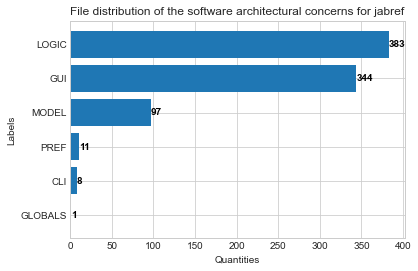

In [5]:
dataset_df = pd.read_csv(raw_data_csv)
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]
tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Quantities')
plt.ylabel('Labels')
plt.title('File distribution of the software architectural concerns for ' + system)

In [6]:
df_columns = [
    'classifier',
    'setting_id',
    'Feature rep.',
    'settings', 
    'accuracy', 
    'macro_precision', 
    'macro_recall',
    'weighted_precision',
    'weighted_recall',
    'macro_f1',
    'weighted_f1',
    'train_size', 
    'test_size', 
    'report_table' 
]
main_table = pd.DataFrame(columns=df_columns)
test_size=0.9
fold_quantity = 100

for setting_id, setting in preprocess_settings.items():
    Prep.preprocess_settings(setting, raw_data_csv, tmp_csv)
    tmp_df = pd.read_csv(tmp_csv)

    # Remove GLOBALS and CLI from the dataset
    df_sliced = Utils.remove_concerns_under_quantity_threshold(tmp_df)

    feature_bow = CountVectorizer()
    feature_tfidf = TfidfVectorizer(use_idf = True)
    confusion_list = []

    # Train and gather evaluation metrics with Bag-Of-Words
    evaluate = Eva.Evaluation(df_sliced, feature_bow, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    row = Utils.make_dataframe_row(metrics_max_ent, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)

    row = Utils.make_dataframe_row(metrics_svm, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)
    
    row = Utils.make_dataframe_row(metrics_naive, setting, "Bag-of-words", setting_id)
    main_table = main_table.append(row, ignore_index=True)
                                     

    # Train and gather evaluation metrics with TF-IDF
    evaluate = Eva.Evaluation(df_sliced, feature_tfidf, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    row = Utils.make_dataframe_row(metrics_max_ent, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)

    row = Utils.make_dataframe_row(metrics_svm, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)
    
    row = Utils.make_dataframe_row(metrics_naive, setting, "TF-IDF", setting_id)
    main_table = main_table.append(row, ignore_index=True)


main_table.to_csv(table_file, index=False)

In [7]:

main_table.sort_values(by='accuracy',ascending=[False])

,classifier,setting_id,Feature rep.,settings,accuracy,macro_precision,macro_recall,weighted_precision,weighted_recall,macro_f1,weighted_f1,train_size,test_size,report_table
1,SVM,s0,Bag-of-words,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.921543,0.673258,0.710544,0.925997,0.921543,0.688188,0.921756,83,752,GUI LOGIC MODEL ...
25,SVM,s4,Bag-of-words,"[[lib, tow, jk, scw, lc, sw, stem], [pac, tow,...",0.917553,0.676895,0.672575,0.924301,0.917553,0.674689,0.920851,83,752,GUI LOGIC MODEL ...
0,MaxEnt,s0,Bag-of-words,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.906915,0.688235,0.742692,0.926094,0.906915,0.707696,0.913465,83,752,GUI LOGIC MODEL ...
24,MaxEnt,s4,Bag-of-words,"[[lib, tow, jk, scw, lc, sw, stem], [pac, tow,...",0.906915,0.896190,0.795971,0.923808,0.906915,0.805868,0.908873,83,752,GUI LOGIC MODEL ...
2,Naive-Bayes,s0,Bag-of-words,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.882979,0.770018,0.684236,0.880799,0.882979,0.715175,0.876728,83,752,GUI LOGIC MODEL ...
3,MaxEnt,s0,TF-IDF,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.877660,0.651706,0.700652,0.902493,0.877660,0.664794,0.883439,83,752,GUI LOGIC MODEL ...
27,MaxEnt,s4,TF-IDF,"[[lib, tow, jk, scw, lc, sw, stem], [pac, tow,...",0.876330,0.710613,0.653491,0.878055,0.876330,0.665199,0.874394,83,752,GUI LOGIC MODEL ...
4,SVM,s0,TF-IDF,"[[lib, tow, jk, scw, lc, stem], [pac, tow, jk]]",0.875000,0.620014,0.647914,0.876207,0.875000,0.630804,0.873240,83,752,GUI LOGIC MODEL ...
26,Naive-Bayes,s4,Bag-of-words,"[[lib, tow, jk, scw, lc, sw, stem], [pac, tow,...",0.875000,0.660659,0.650945,0.879563,0.875000,0.654308,0.876767,83,752,GUI LOGIC MODEL ...
28,SVM,s4,TF-IDF,"[[lib, tow, jk, scw, lc, sw, stem], [pac, tow,...",0.871011,0.625565,0.661682,0.880277,0.871011,0.639262,0.873301,83,752,GUI LOGIC MODEL ...
